## Домашнее задание : "Обучение с подкреплением"

ФИО: Сим Роман Дмитриевич

# Задание 2 - atari

Обучите алгоритм Policy Gradients (или Actor Critic) для среды https://www.gymlibrary.dev/environments/atari/breakout/ . Продемонстрируйте, что для обученного агента растет время игры. (2 балла)

## Preparing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install atari-py
!python -m atari_py.import_roms drive/MyDrive/Roms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%pip install ale-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from ale_py import ALEInterface

ale = ALEInterface()

In [5]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from ale_py.roms import Breakout

ale.loadROM(Breakout)

In [7]:
import torch
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2

In [8]:
import gym
os.environ["SDL_VIDEODRIVER"] = "dummy"
#create a single game instance
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

#start new game
env.reset();

In [ ]:
env.observation_space

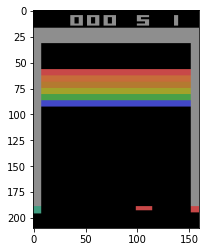

In [10]:
plt.imshow(env.render(mode='rgb_array'))

In [11]:
def preprocess(screen, width=env.observation_space.shape[0], height=env.observation_space.shape[1], targetWidth=84, targetHeight=84):
	# plt.imshow(screen)
	# plt.show()
	screen = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
	screen = screen[20:300, 0:200]  # crop off score
	screen = cv2.resize(screen, (targetWidth, targetHeight))
	screen = screen.reshape(targetWidth, targetHeight) / 255
	# plt.imshow(np.array(np.squeeze(screen)), cmap='gray')
	# plt.show()
	return screen

In [12]:
env.reset()
new_state, _, _, _ = env.step(1)

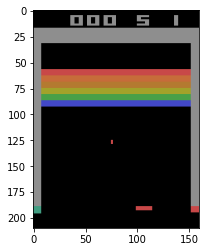

In [13]:
plt.imshow(new_state)

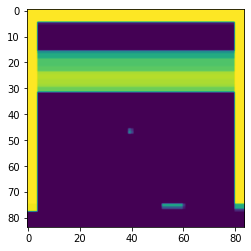

In [14]:
plt.imshow(preprocess(new_state))

## save gifs

In [15]:
import imageio

In [16]:
def save_gif(state_list, gif_name):
    imageio.mimsave(
    f"drive/MyDrive/nn/dz12/{gif_name}.gif",
    state_list,
    fps=24,
)

In [17]:
def make_game(env, atari_nn, gif_name, max_repeat=2000):
    state = env.reset()
    done = False
    renders = []
    i = 0
    repeat_cnt = 0
    env.step(1)

    for i in tqdm(range(max_repeat)):
        renders.append(env.render(mode='rgb_array'))
        state = torch.from_numpy(state).float()
        state = torch.moveaxis(state, 2, 0)
        action = atari_nn.get_next_state(state)
        if action is None:
            next_state, reward, done, _ = env.step(np.random.randint(0, 4))
            state = next_state
            continue

        next_state, reward, done, _ = env.step(action)
        if next_state == state:
            repeat_cnt += 1
        if done:
            break
        state = next_state
        i += 1
    save_gif(renders, gif_name)
    return renders

## AtariNet

In [18]:
class AtariNet(torch.nn.Module):
    def __init__(self, gamma=0.9, loss_coeff=0.4, entropy_coeff=0.6):
        super(AtariNet, self).__init__()
        self.gamma = gamma
        self.loss_coeff = loss_coeff
        self.entropy_coeff = entropy_coeff
        self.action_probs = []
        self.rewards = []

        # 4 канала это 4 последовательных состояния игры
        self.convLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(4, 8, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.convLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.convLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        # 27*40*32

        self.fc1 = torch.nn.Linear(2048, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 4)

    def forward(self, x):
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        x = self.convLayer3(x)
        x = x.flatten()
        x = torch.nn.ReLU()(self.fc1(x))
        x = torch.nn.ReLU()(self.fc2(x))
        x = torch.nn.Softmax()(self.fc3(x))
        return x
    
    def get_next_state(self, env_state):
        env_state = Variable(env_state)
        prob = self.forward(env_state)

        prob = torch.distributions.Categorical(prob) 
        action = prob.sample()
        self.action_probs.append(prob.log_prob(action))

        return action.item()

    def get_loss(self, rewards):
        policy_losses = torch.zeros(len(rewards))
    
        for i, log_prob, reward in zip(np.arange(len(rewards)), self.action_probs, rewards):
            policy_losses[i] = -log_prob*reward

        m = torch.distributions.Categorical(
        logits=torch.cat([x.view(-1) for x in self.action_probs]))
        entropy_loss = (-0.05 * m.entropy()).mean()
        return self.loss_coeff*policy_losses.sum() + self.entropy_coeff*entropy_loss

    def get_discounted_reward(self):

        discounted_reward = np.zeros_like(self.rewards)

        mediate_sum = 0
        for t in reversed(range(len(self.rewards))):
            mediate_sum = mediate_sum * self.gamma + self.rewards[t]
            discounted_reward[t] = mediate_sum

        return discounted_reward
    


## train_function

In [23]:
def train(env, atari_nn, num_episodes=10, repeat_number = 2000):
    max_reward = -1000
    batch_size = 5
    learning_rate = 1e-2
    optimizer = torch.optim.Adam(atari_nn.parameters(), lr=learning_rate)
    episode_durations = []
    state_pool = []
    steps = 0

    for e in range(num_episodes):
        renders = []
        states = []
        state = env.reset()
        state, reward, done, info = env.step(1)
        renders.append(env.render(mode='rgb_array'))
        state = torch.from_numpy(state).float()
        if state.__class__ != np.ndarray:
                state = state.numpy()
        state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
        states.append(state)
        for i in range(3):
          state, reward, done, info = env.step(np.random.randint(0, 4))
          renders.append(env.render(mode='rgb_array'))
          state = torch.from_numpy(state).float()
          if state.__class__ != np.ndarray:
                  state = state.numpy()
          state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
          states.append(state)
        lives = 5

        for t in tqdm(range(repeat_number)):
            renders.append(env.render(mode='rgb_array'))
            action = atari_nn.get_next_state(torch.cat(states, 0))
            
            next_state, reward, done, info = env.step(action)
            if info['lives'] < lives:
                lives = info['lives']
                next_state, _, done, info = env.step(1)
            atari_nn.rewards.append(reward)
            state = next_state
            state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
            del states[0]
            states.append(state)
            if done:
                break
        episode_durations.append(t)

        if sum(atari_nn.rewards) > max_reward:
          max_reward = sum(atari_nn.rewards)
          save_gif(renders, f'best')
        if e%5 == 0:
          save_gif(renders, f'game_{e}')

        optimizer.zero_grad()
        loss = atari_nn.get_loss(atari_nn.get_discounted_reward())
        loss.backward()
            
        optimizer.step()

        print(f'Iteration: {e}; rewards={sum(atari_nn.rewards)}, loss={loss.item()}')
        atari_nn.rewards = []
        atari_nn.action_probs = []

    return episode_durations


In [24]:
net = AtariNet(loss_coeff=0.9, entropy_coeff=1.2)


In [25]:
episode_durations = train(env, net, num_episodes=50)

  0%|          | 0/2000 [00:00<?, ?it/s]

<ipython-input-18-5a5a4ee81bd5>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.fc3(x))


Iteration: 0; rewards=1.0, loss=12.160552024841309


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 1; rewards=7.0, loss=84.02351379394531


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 2; rewards=2.0, loss=25.285634994506836


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 3; rewards=1.0, loss=12.155891418457031


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 4; rewards=2.0, loss=24.261707305908203


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 5; rewards=4.0, loss=49.48455047607422


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 6; rewards=2.0, loss=24.852020263671875


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 7; rewards=0.0, loss=-0.28563979268074036


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 8; rewards=0.0, loss=-0.28459835052490234


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 9; rewards=1.0, loss=12.235461235046387


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 10; rewards=0.0, loss=-0.2851104438304901


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 11; rewards=0.0, loss=-0.2846065163612366


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 12; rewards=3.0, loss=36.79700469970703


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 13; rewards=5.0, loss=61.86177444458008


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 14; rewards=1.0, loss=12.442689895629883


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 15; rewards=6.0, loss=73.7532730102539


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 16; rewards=2.0, loss=24.491029739379883


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 17; rewards=1.0, loss=12.052145004272461


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 18; rewards=1.0, loss=12.402985572814941


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 19; rewards=2.0, loss=24.345151901245117


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 20; rewards=1.0, loss=12.019208908081055


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 21; rewards=1.0, loss=12.124702453613281


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 22; rewards=0.0, loss=-0.2850196361541748


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 23; rewards=1.0, loss=12.136642456054688


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 24; rewards=1.0, loss=11.866764068603516


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 25; rewards=4.0, loss=50.07909393310547


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 26; rewards=2.0, loss=24.409555435180664


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 27; rewards=0.0, loss=-0.28498131036758423


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 28; rewards=3.0, loss=36.66438293457031


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 29; rewards=1.0, loss=12.048492431640625


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 30; rewards=0.0, loss=-0.2854347229003906


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 31; rewards=3.0, loss=37.031673431396484


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 32; rewards=2.0, loss=24.207761764526367


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 33; rewards=0.0, loss=-0.2854183316230774


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 34; rewards=4.0, loss=48.82501983642578


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 35; rewards=0.0, loss=-0.28486692905426025


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 36; rewards=1.0, loss=12.192621231079102


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 37; rewards=0.0, loss=-0.2853160500526428


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 38; rewards=2.0, loss=24.99506187438965


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 39; rewards=0.0, loss=-0.28371304273605347


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 40; rewards=3.0, loss=36.68767547607422


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 41; rewards=1.0, loss=12.001236915588379


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 42; rewards=4.0, loss=49.16371154785156


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 43; rewards=1.0, loss=12.299290657043457


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 44; rewards=3.0, loss=36.033565521240234


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 45; rewards=4.0, loss=49.681480407714844


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 46; rewards=0.0, loss=-0.2852504253387451


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 47; rewards=6.0, loss=74.46455383300781


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 48; rewards=0.0, loss=-0.28435221314430237


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 49; rewards=3.0, loss=36.244300842285156


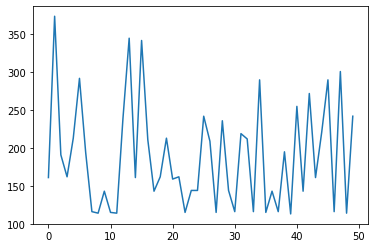

In [26]:
plt.plot(episode_durations)